In [34]:
from LIM_b7 import *

In [35]:
b_150_z0 = 0.32 # eq 21
alpha_90 = -1.5 # slope Ly continuum BUT NOT DETECTED
zpiv = 0.3
zpiv_1 = 1
zpiv_2 = 2

# parameter values: 
# _post = posteriors in table 1 
# _fid = fiducial under fig 3 

e_150_z0_post = pow(10,25.13) / b_150_z0
alpha_150_z0_post = -0.08
alpha_110_z0_post = -3.71

gamma_150_post = 2.06
CA_150_post = 1.85
CA_110_post = 0.50

EW_Lya_z03_post = -6.17
EW_Lya_z1_post = 88.02

fLy_c_z1_post = pow(10,-0.53)
fLy_c_z2_post = pow(10,-0.84)

par_post = [e_150_z0_post,alpha_150_z0_post,gamma_150_post,CA_150_post,alpha_110_z0_post,CA_110_post,EW_Lya_z03_post,EW_Lya_z1_post,fLy_c_z1_post,fLy_c_z2_post]

e_150_z0_fid = pow(10,25.) / b_150_z0
alpha_150_z0_fid = 0.
alpha_110_z0_fid = -3.

gamma_150_fid = 2.
CA_150_fid = 0.
CA_110_fid = 0.

EW_Lya_z1_fid = 88.02 #0.
EW_Lya_z03_fid = -6.17 #0.

fLy_c_z1_fid = pow(10,-5)
fLy_c_z2_fid = pow(10,-5)

par_fid = [e_150_z0_fid,alpha_150_z0_fid,gamma_150_fid,CA_150_fid,alpha_110_z0_fid,CA_110_fid,EW_Lya_z03_fid,EW_Lya_z1_fid,fLy_c_z1_fid,fLy_c_z2_fid]


In [36]:
nu_scale = lambda wavelenght: (cu.c / (wavelenght*u.nm.to(u.m)*u.m)).to(u.Hz)

In [37]:
def e_nu(nu_arr, z, which_par = 'fid'):
    
    e_150_z0, alpha_150_z0, gamma_150, CA_150, alpha_110_z0, CA_110, EW_Lya_z03, EW_Lya_z1, fLy_c_z1, fLy_c_z2 = par_fid if which_par == 'fid' else par_post if which_par == 'post' else []

    e_150 =  e_150_z0 *(1+z)**gamma_150 # continuum emissivity 
    alpha_150 = alpha_150_z0 + CA_150*np.log10(1+z)

    alpha_110 = alpha_110_z0 + CA_110*np.log10(1+z)

    CLya = (EW_Lya_z1 - EW_Lya_z03)/np.log10((1+zpiv_1)/(1+zpiv))
    EW_Lya = ((CLya * np.log10((1+z)/(1+zpiv)) + EW_Lya_z03)*(u.nm)) # equivalent width, can be + (emission) or - (absorption)
    
    CLy_c = (np.log10(fLy_c_z2)-np.log10(fLy_c_z1))/np.log10((1+zpiv_2)/(1+zpiv_1))
    fLy_c = pow(10,CLy_c* np.log10((1+z)/(1+zpiv_1)) + np.log10(fLy_c_z2))# ionizing Ly continuum excape fraction

    e_nu_arr =  np.zeros(len(nu_arr))

    for i in range(len(nu_arr)):

        nu = nu_arr[i]
        if (cu.c / nu).to(u.nm) > (121.6)*u.nm :
        # only continuum 
            e_nu = e_150 * (nu / nu_scale(150))**alpha_150

        elif (cu.c / nu).to(u.nm) == (121.6)*u.nm :
        # line emission
            e_nu = e_150 * (nu_scale(121.6) / nu_scale(150.))**alpha_150 * ((nu / nu_scale(121.6))**alpha_110 +  (EW_Lya*(nu**2)/cu.c)/(1e14*u.Hz)) # !!!

        elif (cu.c / (nu)).to(u.nm) < (121.6)*u.nm and (cu.c / nu).to(u.nm) > (91.2)*u.nm :
        # continuum close to line
            e_nu = e_150 * (nu_scale(121.6) / nu_scale(150.))**alpha_150 * ((nu / nu_scale(121.6))**alpha_110)

        elif (cu.c / nu).to(u.nm) < (91.2)*u.nm :
        # Ly break
            e_nu = fLy_c*e_150*\
            (nu_scale(121.6)/ nu_scale(150.))**alpha_150 \
            *(nu_scale(91.2) / nu_scale(121.6))**alpha_110 \
            * (nu /nu_scale(91.2))**alpha_90

        e_nu_arr[i] = e_nu 

    return e_nu_arr *(u.erg * u.Hz**-1 * u.s**-1 * u.Mpc**-3)


(1e+24, 1e+29)

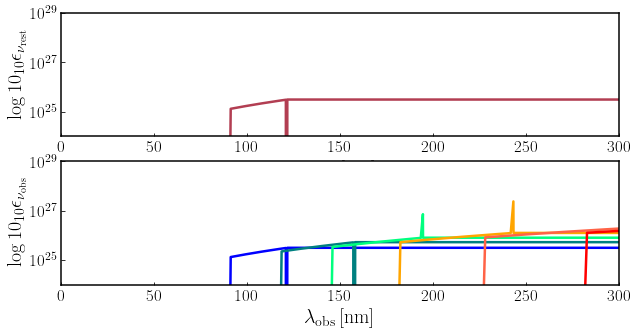

In [38]:
wavelenght = np.concatenate((np.linspace(50,121.6,100),\
                             np.linspace(121.6,121.7,300),np.linspace(121.7,350,100)))

z = [0,0.3,0.6,1,1.5,2.1]
colors = ['b','teal','springgreen','orange','tomato','r']

plt.figure(figsize = (10,5))

nu_rest = nu_scale(wavelenght)
em_rest = e_nu(nu_rest,0.,'fid')

plt.subplot(211)
plt.plot(wavelenght, (em_rest))
plt.xlabel(r'$\lambda_{\rm rest}\,[{\rm nm}]$')
plt.ylabel(r'$\log10_{10}\epsilon_{\nu_{\rm rest}}$')
plt.ylim(1e24,1e29)
plt.yscale('log')
plt.xlim(0,300)

plt.subplot(212)
for zv in z:
    em_obs = e_nu(nu_rest,zv,'fid')

    plt.plot(np.asarray(wavelenght)*(1.+zv), (em_obs),label=r'$z =%g$'%zv,color=colors[z.index(zv)])
    #plt.plot((wavelenght), (em_obs),label=r'$z =%g$'%zv,color=colors[z.index(zv)])
plt.xlabel(r'$\lambda_{\rm obs}\,[{\rm nm}]$')
plt.ylabel(r'$\log10_{10}\epsilon_{\nu_{\rm obs}}$')
plt.yscale('log')
plt.xlim(0,300)
plt.ylim(1e24,1e29)


In [39]:
cosmo_input_camb = dict(
        f_NL=0, H0=67.67, cosmomc_theta=None,
        ombh2=0.0224, omch2=0.1193, omk=0.0, neutrino_hierarchy='degenerate', 
        num_massive_neutrinos=3, mnu=0.06, nnu=3.046, 
        YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046, 
        TCMB=2.7255, tau=0.054, # !!!!
        deltazrei=None, bbn_predictor=None, 
        theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0, 
        dark_energy_model='ppf',As=2.105e-09, ns=0.967, nrun=0., nrunrun=0.0, r=0.0, nt=None, ntrun=0.0, 
        pivot_scalar=0.05, pivot_tensor=0.05,
        parameterization=2,halofit_version='mead')


camb_pars = camb.set_params(\
    H0=cosmo_input_camb['H0'], cosmomc_theta=cosmo_input_camb['cosmomc_theta'],
    ombh2=cosmo_input_camb['ombh2'], omch2=cosmo_input_camb['omch2'], omk=cosmo_input_camb['omk'],
    neutrino_hierarchy=cosmo_input_camb['neutrino_hierarchy'], 
    num_massive_neutrinos=cosmo_input_camb['num_massive_neutrinos'],
    mnu=cosmo_input_camb['mnu'], nnu=cosmo_input_camb['nnu'], YHe=cosmo_input_camb['YHe'], 
    meffsterile=cosmo_input_camb['meffsterile'], 
    standard_neutrino_neff=cosmo_input_camb['standard_neutrino_neff'], 
    TCMB=cosmo_input_camb['TCMB'], tau=cosmo_input_camb['tau'], 
    deltazrei=cosmo_input_camb['deltazrei'], 
    bbn_predictor=cosmo_input_camb['bbn_predictor'], 
    theta_H0_range=cosmo_input_camb['theta_H0_range'],
    w=cosmo_input_camb['w'],  wa=cosmo_input_camb['wa'], cs2=cosmo_input_camb['cs2'], 
    dark_energy_model=cosmo_input_camb['dark_energy_model'],
    As=cosmo_input_camb['As'], ns=cosmo_input_camb['ns'], 
    nrun=cosmo_input_camb['nrun'], nrunrun=cosmo_input_camb['nrunrun'], 
    r=cosmo_input_camb['r'], nt=cosmo_input_camb['nt'], ntrun=cosmo_input_camb['ntrun'], 
    pivot_scalar=cosmo_input_camb['pivot_scalar'], 
    pivot_tensor=cosmo_input_camb['pivot_tensor'],
    parameterization=cosmo_input_camb['parameterization'],
    halofit_version=cosmo_input_camb['halofit_version'])
    

cosmo = camb.get_results(camb_pars)

In [40]:
nu_min_ultrasat = nu_scale(290)
nu_max_ultrasat = nu_scale(250)

nu_ultrasat = (nu_min_ultrasat+nu_max_ultrasat)/2

In [41]:

def R_nu(nu_obs, nu_min, nu_max):

    #window = 1. if nu >=  nu_min and nu < nu_max else 0.
    avg = (nu_min+nu_max)/2.
    sigma = (nu_max-nu_min)/5
    window = np.exp(-(nu_obs-avg)**2/(2*sigma**2))#/(np.sqrt(2*np.pi)*sigma)

    return window # !!!!


def b_nu(nu,z):

    b = b_150_z0 * (nu*u.Hz/nu_scale(150))**-0.86 * (1+z)**0.79

    return b

def bdJ_dz(z,nu,nu_obs):

    Hubble = cosmo.hubble_parameter(z)*(u.km/u.Mpc/u.s)
    tau = cosmo_input_camb['tau'] # !!!

    nu_val = (nu[0]+nu[-1])/2. * u.Hz

    e_nu_val = e_nu([nu_val], z, which_par = 'fid')[0]

    unit = (e_nu_val * np.exp(-tau) * R_nu(nu_obs[0],nu_obs[0],nu_obs[-1]) * b_nu(nu_val.value,z).value / nu_obs[0]*u.Hz).unit
     
    integrand = lambda nu_obs_val:  (e_nu_val * np.exp(-tau) * R_nu(nu_obs_val*u.Hz,nu_obs[0],nu_obs[-1])* b_nu(nu_val.value,z).value / nu_obs_val).value

    dJdz = ((cu.c/(4*np.pi*Hubble*(1.+z)) *quad(integrand,nu_obs[0].value,nu_obs[-1].value)[0]*unit*u.steradian**-1)).to(u.Jy/u.steradian)
    

    return dJdz 

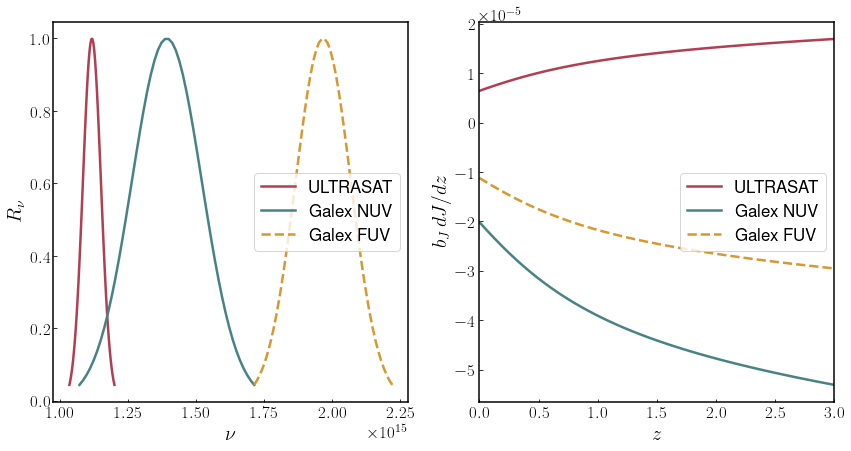

In [42]:
nu_min_galex = nu_scale(175)
nu_max_galex = nu_scale(280)

nu_min_galex_f = nu_scale(135)
nu_max_galex_f = nu_scale(175)

nu_v = np.linspace(nu_min_ultrasat,nu_max_ultrasat)
nu_v_g = np.linspace(nu_min_galex,nu_max_galex)
nu_v_gf = np.linspace(nu_min_galex_f,nu_max_galex_f)

Rnu = np.zeros(len(nu_v))
Rnu_g = np.zeros(len(nu_v))
Rnu_gf = np.zeros(len(nu_v))
for i in range(len(nu_v)):
    Rnu[i] = R_nu(nu_v[i],nu_min_ultrasat,nu_max_ultrasat).value
for i in range(len(nu_v_g)):
    Rnu_g[i] = R_nu(nu_v_g[i],nu_min_galex,nu_max_galex).value
for i in range(len(nu_v_gf)):
    Rnu_gf[i] = R_nu(nu_v_gf[i],nu_min_galex_f,nu_max_galex_f).value

plt.figure()
plt.subplot(121)
plt.plot(nu_v,Rnu,label='ULTRASAT')
plt.plot(nu_v_g,Rnu_g, label='Galex NUV')
plt.plot(nu_v_gf,Rnu_gf,label='Galex FUV',linestyle='--')
plt.xlabel(r'$\nu$')
plt.ylabel(r'$R_\nu$')
plt.legend()

zvals = np.linspace(0,3)
dJ = np.zeros(len(zvals))
dJ_g = np.zeros(len(zvals))
dJ_g_f = np.zeros(len(zvals))
for i in range(len(zvals)):
    dJ[i] = bdJ_dz(zvals[i],np.asarray(nu_rest),nu_v).value
    dJ_g[i] = bdJ_dz(zvals[i],np.asarray(nu_rest),nu_v_g).value
    dJ_g_f[i] = bdJ_dz(zvals[i],np.asarray(nu_rest),nu_v_gf).value

plt.subplot(122)
plt.plot(zvals,dJ,label='ULTRASAT')
plt.plot(zvals,dJ_g,label='Galex NUV')
plt.plot(zvals,dJ_g_f,label='Galex FUV',linestyle='--')
plt.xlabel(r'$z$')
plt.ylabel(r'$b_J\,dJ/dz$')
plt.xlim(0,3)
plt.legend()

(0.0, 3.0)

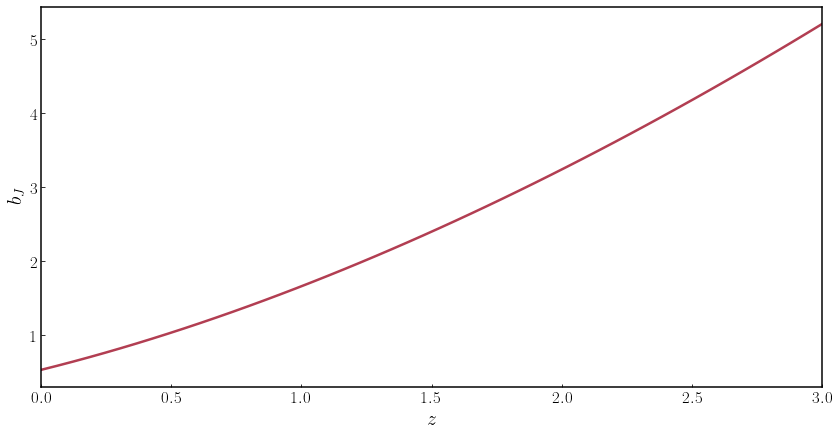

In [43]:
def bJ(z,nu_arr):

    tau = cosmo_input_camb['tau'] # !!!

    nu_arr = nu_arr/(1+z)

    e_nu_val = lambda nu_val: e_nu([nu_val*u.Hz], z, which_par = 'fid').value 

    integrand = lambda nu_val:  e_nu_val(nu_val) * np.exp(-tau)/ nu_val * b_nu(nu_val,z).value*(R_nu(nu_val,nu_arr[0].value,nu_arr[-1].value) )

    integrand_den = lambda nu_val:  e_nu_val(nu_val) * np.exp(-tau)/ nu_val *(R_nu(nu_val,nu_arr[0].value,nu_arr[-1].value) )

    bJ = (quad(integrand,nu_arr[0].value,nu_arr[-1].value)[0])/(quad(integrand_den,nu_arr[0].value,nu_arr[-1].value)[0])

    return bJ 

zvals = np.linspace(0.,3.)
bJv = np.zeros(len(zvals))
for i in range(len(zvals)):
    bJv[i] = bJ(zvals[i],np.linspace(nu_min_ultrasat,nu_max_ultrasat))

plt.plot(zvals,bJv)
plt.xlabel(r'$z$')
plt.ylabel(r'$b_J$')
plt.xlim(0,3)
